In [1]:
import sys
import collections
from collections import Counter, defaultdict

import datetime
from datetime import datetime, timedelta, timezone
import dateutil.parser

import statistics
from statistics import median
from itertools import zip_longest

import pytz
from pytz import timezone

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

import pydent
from pydent import AqSession, models
from pydent.models import Sample, Item, Plan

sys.path.append("../ext-plan-pydent")
from plans import ExternalPlan

In [2]:
session = ExternalPlan.create_session("production")

Connected to Aquarium at http://52.27.43.242/ using pydent version 0.0.35
Logged in as Devin Strickland



../ext-plan-pydent/plans.py:69: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [3]:
def get_completed_jobs(operation_type):
    ops = session.Operation.where({"operation_type_id": operation_type.id, 'status': 'done'})
    print("Found {} Operations of type {}".format(len(ops), operation_type.name))

    op_ids = [op.id for op in ops]
    job_associations = session.JobAssociation.where({"operation_id": op_ids})

    job_ids = [ja.job_id for ja in job_associations]
    jobs = session.Job.find(job_ids)
    jobs = [j for j in jobs if j.state[-1]['operation'] == "complete"]
    print("Found {} completed Jobs of type {}".format(len(jobs), operation_type.name))
    
    return jobs

In [4]:
def get_delta(times):
    start = dateutil.parser.parse(times[0])
    end = dateutil.parser.parse(times[1])
    return (end - start).seconds/60

def get_step_times(state):
    times = [s["time"] for s in state if s["operation"] == "next"]
    step_times = []
    
    i = 0
    while i < (len(times) - 1):
        step_times.append(get_delta([times[i], times[i+1]]))
        i += 1
    
    return step_times

In [5]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    
def get_job_stats(operation_type, window_start=None):
    job_stats = []
    
    query = "operation_type_id = {} AND status = 'done'".format(operation_type.id)
        
    if window_start:
        query += " AND updated_at >= '{}'".format(window_start)
        
    operations = session.Operation.where(query)
    print("Found {} Operations of type {}".format(len(operations), operation_type.name))

    op_ids = [op.id for op in operations]
    job_associations = session.JobAssociation.where({"operation_id": op_ids})

    job_ids = list(set([ja.job_id for ja in job_associations]))
    nested_job_ids = chunks(job_ids, 25)        
    jobs = []
    
    for these_job_ids in nested_job_ids:
        jobs += session.Job.find(these_job_ids)
                    
    print("Found {} completed Jobs of type {}".format(len(jobs), operation_type.name))
    
    for job in jobs:
        if len(job.state) < 5:
            continue
        js = {}
        js["id"] = job.id
        these_job_associations = [j for j in job_associations if j.job_id == job.id]
        js["n_ops"] = len(these_job_associations)
        js["start_time"] = job.state[2].get('time')
        js["stop_time"] = job.state[-2].get('time')
        
        if js["start_time"] and js["stop_time"]:
            js["duration"] = get_delta((js["start_time"], js["stop_time"]))
            
        js["step_times"] = get_step_times(job.state)
        js["length"] = len([s for s in job.state if s["operation"] == "display"])
        js["job_completeness"] = job.is_complete
        js["state_completeness"] = job.state[-1]['operation']
        js["complete"] = job.is_complete and job.state[-1]['operation'] == "complete"
        job_stats.append(js)
    
    return job_stats

columns = [
    "n_ops", 
    "start_time", 
    "stop_time", 
    "duration", 
    "length", 
    "job_completeness", 
    "state_completeness", 
    "complete"
]

In [6]:
pacific = timezone('US/Pacific')

window_start = pacific.localize(datetime(2018, 9, 22))
print(window_start)

2018-09-22 00:00:00-07:00


In [9]:
# categories = [
#     'Cloning',
#     'Yeast'
# ]

# operation_types = session.OperationType.where({'category': categories})

operation_type_names = [
    "Pour High-Volume Gel",
    "High-Volume Restriction Digest",
    "Run High-Volume Gel",
    "Extract High-Volume Gel",
    "Purify on Column",
    "Transfer Samples to Stripwell",
    "Combine Purified Samples",
    "Purify High-Volume Gel",
    "Streak on Media Plate",
    "Check Plates Pre-transformation",
    "Innoc. Library Preculture",
    "Dilute Library Preculture",
    "High-Efficiency Comp Cells",
    "Combine and Dry DNA",
    "Estimate Transformation Efficiency",
    "Make Library Glycerol Stocks",
    "High-Efficiency Transformation NEW",
    "Resuspend Oligo Pool"
]

operation_types = session.OperationType.where({"name": operation_type_names})

found_ot_names = [ot.name for ot in operation_types]
not_found = [n for n in operation_type_names if not n in found_ot_names]
print(not_found)

['Pour High-Volume Gel', 'High-Volume Restriction Digest', 'Run High-Volume Gel', 'Extract High-Volume Gel', 'Purify on Column', 'Transfer Samples to Stripwell', 'Combine Purified Samples', 'Purify High-Volume Gel', 'Streak on Media Plate', 'Check Plates Pre-transformation', 'Innoc. Library Preculture', 'Dilute Library Preculture', 'High-Efficiency Comp Cells', 'Combine and Dry DNA', 'Estimate Transformation Efficiency', 'Make Library Glycerol Stocks', 'High-Efficiency Transformation NEW', 'Resuspend Oligo Pool']


In [10]:
ot_data = []
for operation_type in operation_types:
    jobs = get_job_stats(operation_type, window_start)
    ot_data.append((operation_type, jobs))

Found 13 Operations of type Pour High-Volume Gel
Found 10 completed Jobs of type Pour High-Volume Gel
Found 26 Operations of type High-Volume Restriction Digest
Found 29 completed Jobs of type High-Volume Restriction Digest
Found 11 Operations of type Run High-Volume Gel
Found 9 completed Jobs of type Run High-Volume Gel
Found 10 Operations of type Extract High-Volume Gel
Found 8 completed Jobs of type Extract High-Volume Gel
Found 9 Operations of type Purify on Column
Found 3 completed Jobs of type Purify on Column
Found 0 Operations of type Transfer Samples to Stripwell
Found 0 completed Jobs of type Transfer Samples to Stripwell
Found 20 Operations of type Combine Purified Samples
Found 19 completed Jobs of type Combine Purified Samples
Found 6 Operations of type Purify High-Volume Gel
Found 5 completed Jobs of type Purify High-Volume Gel
Found 46 Operations of type Streak on Media Plate
Found 32 completed Jobs of type Streak on Media Plate
Found 4 Operations of type Check Plates Pr

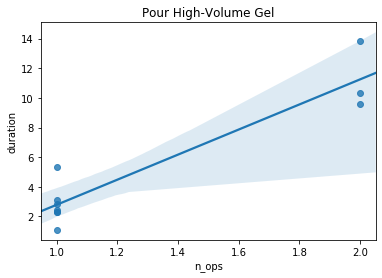

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


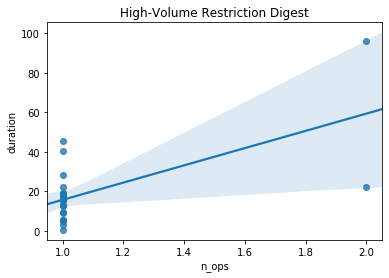

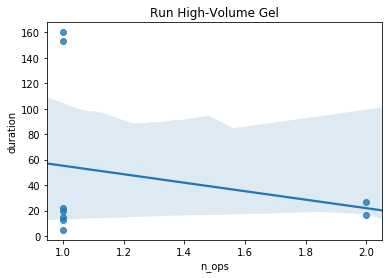

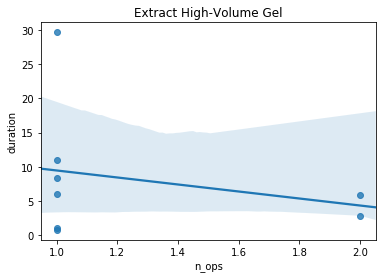

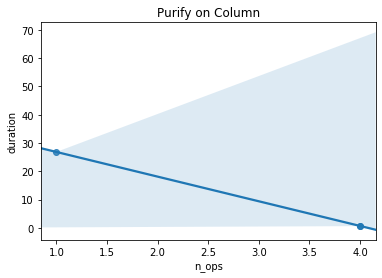

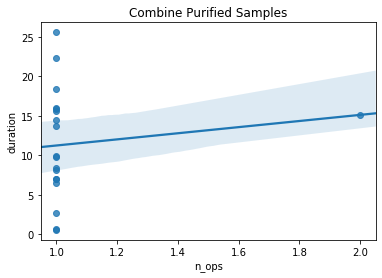

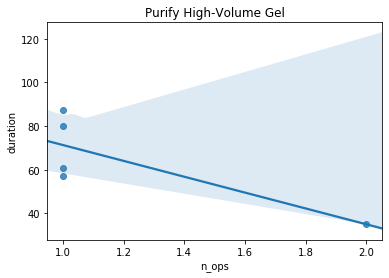

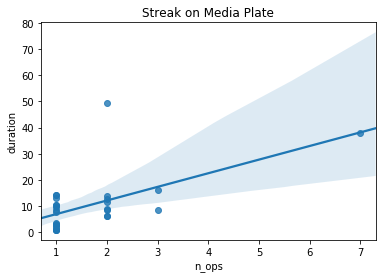

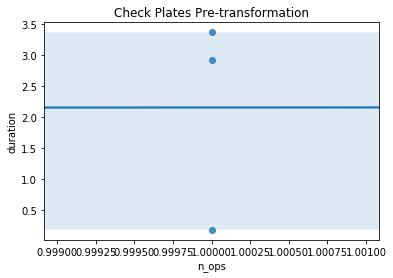

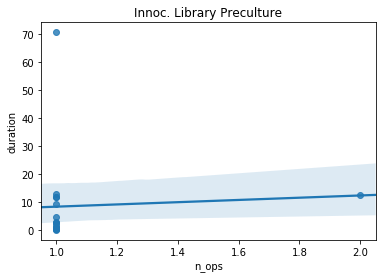

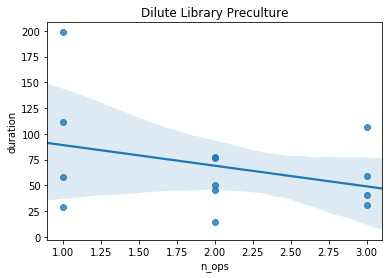

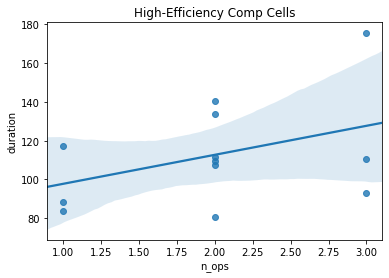

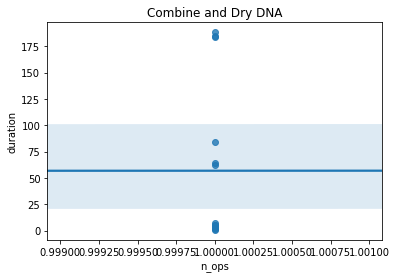

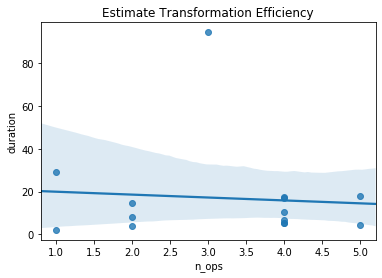

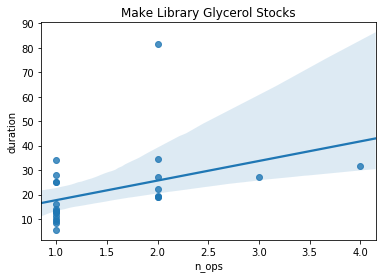

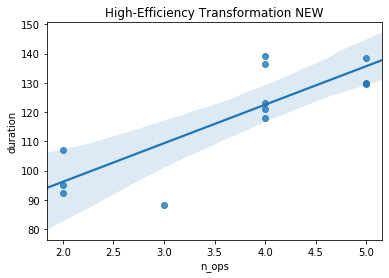

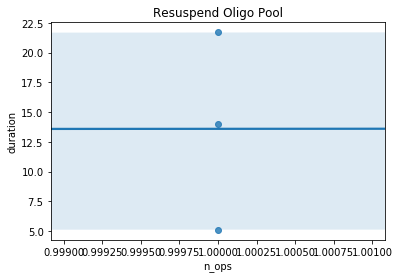

,job_name,num,mean_time,median_time,mean_size,median_size,mean_time_per_operation,median_time_per_operation
0,Pour High-Volume Gel,10,5.325000,2.975000,1.300000,1.0,3.637500,2.975000
1,High-Volume Restriction Digest,26,19.089744,15.958333,1.076923,1.0,16.805769,15.725000
2,Run High-Volume Gel,9,47.846296,19.333333,1.222222,1.0,45.411111,15.266667
3,Extract High-Volume Gel,8,8.175000,5.900000,1.250000,1.0,7.633333,4.441667
4,Purify on Column,3,9.400000,0.733333,3.000000,4.0,9.062500,0.183333
5,Combine Purified Samples,19,11.448246,9.900000,1.052632,1.0,11.050439,9.833333
6,Purify High-Volume Gel,5,64.076667,60.816667,1.200000,1.0,60.576667,60.816667
7,Streak on Media Plate,28,10.241667,8.566667,1.642857,1.0,6.391454,4.891667
8,Check Plates Pre-transformation,3,2.155556,2.916667,1.000000,1.0,2.155556,2.916667
9,Innoc. Library Preculture,17,8.676471,2.600000,1.058824,1.0,8.310784,2.600000


In [11]:
output_columns = [
    "job_name",
    "num", 
    "mean_time", 
    "median_time", 
    "mean_size", 
    "median_size", 
    "mean_time_per_operation", 
    "median_time_per_operation"
]

output_data = []

for operation_type, jobs in ot_data:
    all_data = pd.DataFrame(data=jobs, columns=columns)
    completed_data = all_data[all_data["complete"]]
    
    if completed_data.get("duration") is None: continue
        
    completed_data["time_per_operation"] = completed_data["duration"] / completed_data["n_ops"]
    ax = sns.regplot(x="n_ops", y="duration", data=completed_data)
    ax.set_title(operation_type.name)
    plt.show()
    
    summary = completed_data.describe()
    output_row = {}
    output_row["job_name"] = operation_type.name
    output_row["num"] = len(completed_data)
    output_row["mean_time"] = summary["duration"]["mean"]
    output_row["median_time"] = summary["duration"]["50%"]
    output_row["mean_size"] = summary["n_ops"]["mean"]
    output_row["median_size"] = summary["n_ops"]["50%"]
    
    if summary.get("time_per_operation") is not None:
        output_row["mean_time_per_operation"] = summary["time_per_operation"]["mean"]
        output_row["median_time_per_operation"] = summary["time_per_operation"]["50%"]
        
    output_data.append(output_row)
    
output_df = pd.DataFrame(data=output_data, columns=output_columns)
output_df
#     times = [j["step_times"] for j in jobs]
#     temp = [t[0] for t in times]
#     time_data = pd.DataFrame(data=times)
#     print(time_data.shape)
#     print(len(jobs))
#     print((max([j["length"] for j in jobs])))
#     df_first_row = list(time_data.iloc[1])
#     fig, ax = plt.subplots()
#     fig.set_size_inches(20, 5)
#     sns.swarmplot(data=time_data, size=4)
#     ax.set_title(operation_type.name)
#     ax.set_xlabel("step")
#     ax.set_ylabel("duration")
#     plt.show()

In [12]:
output_df.to_csv("job_stats.csv", index=False)

In [ ]:
deltas = []

for time in times:
    start = dateutil.parser.parse(time[0])
    end = dateutil.parser.parse(time[1])
    delta = (end - start).seconds/60
    deltas.append(delta)

In [ ]:
sns.distplot(deltas, kde=False)
print(median([d for d in deltas if d < 500]))
data = list(zip(lengths, completeness, state_completeness))
data.sort(key=lambda x: x[0])
for d in data:
    print(d)

In [3]:
job = session.Job.find(92183)

In [6]:
print(job.state[1])

{'operation': 'display', 'content': [{'title': 'Boxes Required'}, {'note': 'You will need the following boxes from the freezer(s)'}, {'table': [[{'content': 'M20.23.4', 'check': True}, {'content': 'M20.23.13', 'check': True}, {'content': 'M20.24.1', 'check': True}, {'content': 'M20.24.2', 'check': True}, {'content': 'M20.24.3', 'check': True}, {'content': 'M20.24.4', 'check': True}]]}]}
